Here we would like to use machine learning method to predict the interacion between two particles. The idea is that we have the information,eg. position and velocity of the two particles, then we use the NN to predict the time of interaction and the information of the particles(again position and velocity) just after the interaction. If we can do this, the time step could be increased to each collition time which is much higher than the traditional timestep.

In the system, we consider the interaction between two particles with equal mass m and interaction radius d0. One of the particle is placed at $r_1 = (x_1,y_1)$ with velocity $v_1 = (v_{x1},v_{y1})$, where $x_1 = 0$, $y_1 = 0$, $v_{y1} = 1$, $v_{x1} = [0.5,1.5]$ with step $\delta v = 0.005$, and another particle is placed at $r_2 = (x_2,y_2)$ with velocity $v_2 = (v_{x2},v_{y2})$ where $x_2 = 2.05$, $v_{x2} = 0$, $v_{y2} = 0$ and $y_2 = [−2.0,2.0]$ with step $\delta y = 0.001$. We first need to import the data that we have already generated.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from sklearn.model_selection import train_test_split


def load_data(batch_size=1):
  int_time = np.load('gdrive/My Drive/int_time_train_short.npy', allow_pickle=True)      ### The dimension of the import data is [x,y,v_x,t_start,t_end], t_start is the time to start interaction, t_end is the time to end interaction
  int_time_inputs = int_time[:,:3]
  int_time_outputs = int_time[:,3:]

  ### Here to split the data into train, valid and test set###
  int_time_inputs, int_time_inputs_valid, int_time_outputs, int_time_outputs_valid = train_test_split(int_time_inputs, int_time_outputs, test_size=0.2,train_size=0.8)
  int_time_inputs_train, int_time_inputs_test, int_time_outputs_train, int_time_outputs_test = train_test_split(int_time_inputs, int_time_outputs, test_size=0.2,train_size=0.8)

  int_time_inputs_train = torch.FloatTensor(int_time_inputs_train)
  int_time_outputs_train = torch.FloatTensor(int_time_outputs_train)
  int_time_inputs_valid = torch.FloatTensor(int_time_inputs_valid)
  int_time_outputs_valid = torch.FloatTensor(int_time_outputs_valid)
  int_time_inputs_test = torch.FloatTensor(int_time_inputs_test)
  int_time_outputs_test = torch.FloatTensor(int_time_outputs_test)

  ### To remove the data where there is no interaction between the particles ###
  int_time_outputs_train, indice = zero_start_interation_to_non_zero(int_time_outputs_train)
  int_time_inputs_train = int_time_inputs_train[indice]
  int_time_outputs_valid, indice = zero_start_interation_to_non_zero(int_time_outputs_valid)
  int_time_inputs_valid = int_time_inputs_valid[indice]
  int_time_outputs_test, indice = zero_start_interation_to_non_zero(int_time_outputs_test)
  int_time_inputs_test = int_time_inputs_test[indice]

  int_time_train_data = TensorDataset(int_time_inputs_train.to(device=device), int_time_outputs_train.to(device=device))
  int_time_valid_data = TensorDataset(int_time_inputs_valid.to(device=device), int_time_outputs_valid.to(device=device))
  int_time_test_data = TensorDataset(int_time_inputs_test.to(device=device), int_time_outputs_test.to(device=device))

  int_time_train_data_loader = DataLoader(int_time_train_data, batch_size=batch_size)
  int_time_valid_data_loader = DataLoader(int_time_valid_data, batch_size=batch_size)
  int_time_test_data_loader = DataLoader(int_time_test_data, batch_size=batch_size)

  return int_time_train_data_loader, int_time_valid_data_loader, int_time_test_data_loader

def zero_start_interation_to_non_zero(tensor):
	indice = tensor[:,0]!=1e10
	indice = indice.nonzero().flatten()
	tensor = tensor[indice]
	return tensor, indice

In [3]:
batch_size = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
int_time_train_data_loader, int_time_valid_data_loader, int_time_test_data_loader = load_data(batch_size=batch_size)

For the simplicity, we use COM frame to reduce a lot of vaiable in the system.From the properties of COM frame, we can then reduce the number of variables in the system, where $r′_1 = −r′_2$ and $v′_1 = −v′_2$. 

In [4]:
def rotation_matrix(theta):
	c = torch.cos(theta)
	s = torch.sin(theta)
	R1 = torch.stack( (c,-s), dim=-1)
	R2 = torch.stack( (s,c), dim=-1)
	R = torch.stack( (R1,R2), dim=-2)
	return R

def COM_frame(r, v):
	R = (r[:,0,:] + r[:,1,:])/2 		# position of COM
	V = (v[:,0,:] + v[:,1,:])/2 		# velocity of COM
	
	r = r - R[:,None]
	v = v - V[:,None]

	theta = -torch.atan2(v[:,0,1],v[:,0,0])
	Rot = rotation_matrix(theta)

	r = torch.transpose(torch.bmm(Rot,torch.transpose(r,-1,-2)),-1,-2)
	v = torch.transpose(torch.bmm(Rot,torch.transpose(v,-1,-2)),-1,-2)

	L = torch.sqrt((torch.sum(torch.square(r[:,0,:] - r[:,1,:]), -1)))
	U = v[:,0,0]
	phi = torch.atan2(r[:,0,1],r[:,0,0])
	return r, v, R, V, theta, L, U, phi

def transform_to_full_data_set(data):
	## As I used 1st particle frame in generating data, here is to transform back the general coordinate
	r1x, r1y, v1x, v1y = torch.zeros((len(data))), torch.zeros((len(data))), torch.zeros((len(data))), torch.zeros((len(data)))
	r2x, r2y, v2x, v2y = data[:,0], data[:,1], data[:,2], torch.zeros((len(data)))
	
	
	r1x, r1y, v1x, v1y = r1x.to(device=device), r1y.to(device=device), v1x.to(device=device), v1y.to(device=device)
	r2x, r2y, v2x, v2y = r2x.to(device=device), r2y.to(device=device), v2x.to(device=device), v2y.to(device=device)
	
	r1 = torch.cat((r1x[:,None],r1y[:,None]), -1)
	r2 = torch.cat((r2x[:,None],r2y[:,None]), -1)
	v1 = torch.cat((v1x[:,None],v1y[:,None]), -1)
	v2 = torch.cat((v2x[:,None],v2y[:,None]), -1)		
	
	r = torch.cat((r1[:,None,:],r2[:,None,:]), 1)
	v = torch.cat((v1[:,None,:],v2[:,None,:]), 1)
	return r,v

Then we can define the structure of the neural network, in the interacting_particle_NN, we first transform the system to COM frame and then input the data $(x,v,v_x)$ into the submodel int_time_NN to predict the time of interaction.

In [5]:
class int_time_NN(nn.Module):

  def __init__(self, n_hid, num_levels):
    super(int_time_NN, self).__init__()
    self.hl1 = nn.Linear(3,n_hid)
    self.linear = nn.Linear(n_hid,n_hid)
    self.ol = nn.Linear(n_hid,1)
    self.relu = nn.ReLU()

    layers = []
    for i in range(num_levels):
      layers += [nn.Sequential(self.linear, self.relu)]
    self.hl2 = nn.Sequential(*layers)


  def forward(self, inputs):
    x = inputs
    x  = self.relu(self.hl1(x))
    x  = self.hl2(x)
    x  = self.relu(self.ol(x))
    return x

class interacting_particle_NN(nn.Module):
  def __init__(self, submodel):
    super(interacting_particle_NN, self).__init__()
    self.int_time = submodel

  def forward(self, r, v):
    ##  Transformation to Center of Mass Frame
    r, v, R, V, theta, L, U, phi = COM_frame(r, v)
    num_sample = r.size(0)

    y = r[:,0,1][:,None]
    x = r[:,0,0][:,None]
    radius = torch.tensor([2.0]).repeat(num_sample,1).to(device=device)   ## The interaction radius of the particle
    x_int = -torch.sqrt(torch.square(radius/2) - torch.square(y))         ## The x-coordinate when the interaction start
    v_int = v[:,0,0][:,None]                                              ## v_x when the interaction start
    inputs = torch.cat((x_int ,y ,v_int),-1)                              ## Feature for the neural network
    outputs = self.int_time(inputs)                                       ## Predicted interaction time from NN
    return outputs, inputs

Then we write our train function and the test function to train the NN

In [6]:
def train(train_data_loader, valid_data_loader, max_epoch, model, submodel):

  optimizer = optim.Adam(list(model.parameters()), lr=lr)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)
  best_val_loss = np.inf
  best_epoch = 0

  for epoch in range(max_epoch):
    t = time.time()
    loss_train = []
    loss_val = []
    model.train()
    for batch_idx, (data, targets) in enumerate(train_data_loader):
      targets = (targets[:,1] - targets[:,0])       ## Interaction time = end time - start time
      targets = targets[:,None]                     
      r, v = transform_to_full_data_set(data)       ## To obtain the full data set of r and v for both particles
      optimizer.zero_grad()
      output, inputs = model(r, v)
      loss = F.mse_loss(output, targets)            ## Compute the loss between the prediction and targets
      loss.backward()
      optimizer.step()
      scheduler.step()
      loss_train.append(loss.data.detach().cpu().numpy())

    model.eval()
    for batch_idx, (data, targets) in enumerate(valid_data_loader):
      with torch.no_grad():
        targets = (targets[:,1] - targets[:,0])
        targets = targets[:,None]
        r, v = transform_to_full_data_set(data)
        output, inputs = model(r, v)
        loss = F.mse_loss(output, targets)
        loss_val.append(loss.data.detach().cpu().numpy())

    print('Epoch: {:04d}'.format(epoch),
    'loss_train: {:.10f}'.format(np.mean(loss_train)),
    'loss_val: {:.10f}'.format(np.mean(loss_val)),
    'time: {:.4f}s'.format(time.time() - t))

    val_loss = np.mean(loss_val)
    if val_loss < best_val_loss:
      best_epoch = epoch
      best_val_loss = val_loss
      best_model = model.state_dict()
  print("Optimization Finished!")
  print("Best Epoch Loss: ", best_val_loss)
  print("Best Epoch: {:04d}".format(best_epoch))
  return best_model

def test(test_data_loader, model, submodel):
    t = time.time()
    loss_test = []
    input_list = []
    output_list = []
    targets_list = []
    model.eval()
    model.load_state_dict(best_model)
    for batch_idx, (data, targets) in enumerate(test_data_loader):
      with torch.no_grad():
          targets = (targets[:,1] - targets[:,0])
          targets = targets[:,None]

          r, v = transform_to_full_data_set(data)
          output, inputs = model(r, v)
          loss = F.mse_loss(output, targets)
          loss_test.append(loss.data.detach().cpu().numpy())
          output_list.append(output.data.detach().cpu().numpy())
          targets_list.append(targets.data.detach().cpu().numpy())
          input_list.append(inputs.data.detach().cpu().numpy())
    print('loss_test: {:.10f}'.format(np.mean(loss_test)))
    output = np.concatenate(output_list, axis=0)
    targets = np.concatenate(targets_list, axis=0)
    input = np.concatenate(input_list, axis=0)
    results = np.empty((len(targets),5))
    for i in range(len(targets)):
      results[i,0] = output[i,0]
      results[i,1] = targets[i,0]
      results[i,2] = input[i,0]
      results[i,3] = input[i,1]
      results[i,4] = input[i,2]
    return results

Then, we can train and test the NN with the training data

In [7]:
n_hid = 32
num_levels = 2
lr = 1e-2
max_epoch = 5

submodel = int_time_NN(n_hid=n_hid, num_levels=num_levels).to(device=device)
model = interacting_particle_NN(submodel).to(device=device)

best_model = train(int_time_train_data_loader, int_time_valid_data_loader, max_epoch, model, submodel)

Epoch: 0000 loss_train: 0.1042714566 loss_val: 0.0144123379 time: 7.0759s
Epoch: 0001 loss_train: 0.0144416485 loss_val: 0.0143929385 time: 6.5481s
Epoch: 0002 loss_train: 0.0144378850 loss_val: 0.0143928900 time: 6.5673s
Epoch: 0003 loss_train: 0.0144378794 loss_val: 0.0143928900 time: 6.6382s
Epoch: 0004 loss_train: 0.0144378794 loss_val: 0.0143928900 time: 6.6610s
Optimization Finished!
Best Epoch Loss:  0.01439289
Best Epoch: 0002


In [8]:
results = test(int_time_test_data_loader, model, submodel)

loss_test: 0.0144910943


After we get the test result from training the neural network, we can then visualize the result by plotting graph

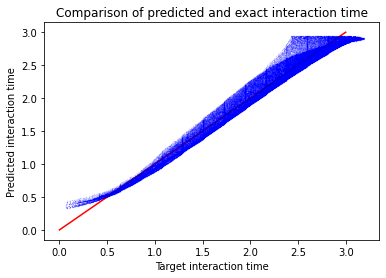

In [9]:
import matplotlib.pyplot as plt 
#plt.axline((1, 1), slope=1, color='r')
def plot(results):
  plt.plot([0,1, 2, 3], c='r')
  plt.plot(results[:,1], results[:,0], color = 'b', marker=".", markersize=0.05,ls='None')
  plt.xlabel('Target interaction time')
  plt.ylabel('Predicted interaction time')
  plt.title('Comparison of predicted and exact interaction time')
  plt.show()

plot(results)

Then we try to modify our NN in order to obtain a better prediction of interaction time. We first start with a initial guess of interaction $t_0$ which is equal to the time to travel the interaction region but without the influence of interaction, eg.$t_0 = x/v$. We can assume that the exact time of interaction is just a factor of it, eg. $t = αt_0$.

In [10]:
class int_time_NN2(nn.Module):

	def __init__(self, n_hid, num_levels):
		super(int_time_NN2, self).__init__()
		self.hl1 = nn.Linear(4,n_hid)
		self.linear = nn.Linear(n_hid,n_hid)
		self.ol = nn.Linear(n_hid,1)
		self.relu = nn.ReLU()
		
		layers = []
		for i in range(num_levels):
			layers += [nn.Sequential(self.linear, self.relu)]
		self.hl2 = nn.Sequential(*layers)
		

	def forward(self, inputs):
		x = inputs[:,0]
		y = inputs[:,1]
		v = inputs[:,2]
		t0 = torch.abs(x/v)
		x = x[:,None]
		y = y[:,None]
		v = v[:,None]
		t0 = t0[:,None]

		x = torch.cat((y,t0,x,v),axis=-1)
		x  = self.relu(self.hl1(x))
		x  = self.hl2(x)
		x  = self.ol(x)
		x = x*t0
		return x


Epoch: 0000 loss_train: 0.0932002515 loss_val: 0.0058868304 time: 7.3368s
Epoch: 0001 loss_train: 0.0059159086 loss_val: 0.0058704810 time: 6.8500s
Epoch: 0002 loss_train: 0.0059128092 loss_val: 0.0058704419 time: 6.6549s
Epoch: 0003 loss_train: 0.0059128050 loss_val: 0.0058704419 time: 6.8183s
Epoch: 0004 loss_train: 0.0059128050 loss_val: 0.0058704419 time: 6.7720s
Optimization Finished!
Best Epoch Loss:  0.005870442
Best Epoch: 0002
loss_test: 0.0059733749


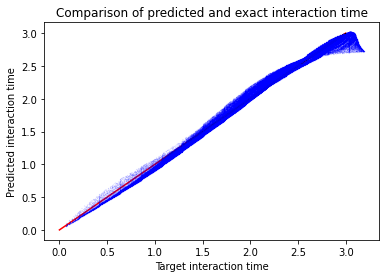

In [11]:
submodel = int_time_NN2(n_hid=n_hid, num_levels=num_levels).to(device=device)
model = interacting_particle_NN(submodel).to(device=device)

best_model = train(int_time_train_data_loader, int_time_valid_data_loader, max_epoch, model, submodel)
results = test(int_time_test_data_loader, model, submodel)
plot(results)

It seems it is a little bit better at the region of small time of interaction. We try a little more modification. We assume that the exact time of interaction is the sum of itself and a factor, eg. $t = t_0 + αt_0$

In [12]:
class int_time_NN3(nn.Module):

	def __init__(self, n_hid, num_levels):
		super(int_time_NN3, self).__init__()
		self.hl1 = nn.Linear(4,n_hid)
		self.linear = nn.Linear(n_hid,n_hid)
		self.ol = nn.Linear(n_hid,1)
		self.relu = nn.ReLU()
		
		layers = []
		for i in range(num_levels):
			layers += [nn.Sequential(self.linear, self.relu)]
		self.hl2 = nn.Sequential(*layers)
		

	def forward(self, inputs):
		x = inputs[:,0]
		y = inputs[:,1]
		v = inputs[:,2]
		t0 = torch.abs(x/v)
		x = x[:,None]
		y = y[:,None]
		v = v[:,None]
		t0 = t0[:,None]

		x = torch.cat((y,t0,x,v),axis=-1)
		x  = self.relu(self.hl1(x))
		x  = self.hl2(x)
		x  = self.ol(x)
		x = t0 + x*t0
		return x

Epoch: 0000 loss_train: 0.0095429355 loss_val: 0.0012940387 time: 6.9155s
Epoch: 0001 loss_train: 0.0012901124 loss_val: 0.0012815167 time: 7.0370s
Epoch: 0002 loss_train: 0.0012877074 loss_val: 0.0012814769 time: 6.7363s
Epoch: 0003 loss_train: 0.0012877022 loss_val: 0.0012814769 time: 6.8816s
Epoch: 0004 loss_train: 0.0012877022 loss_val: 0.0012814769 time: 6.8054s
Optimization Finished!
Best Epoch Loss:  0.0012814769
Best Epoch: 0002
loss_test: 0.0012950398


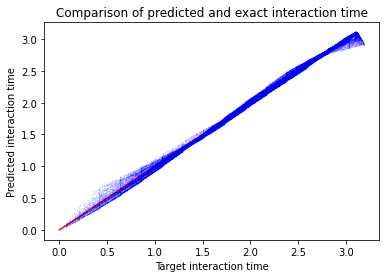

In [13]:
submodel = int_time_NN3(n_hid=n_hid, num_levels=num_levels).to(device=device)
model = interacting_particle_NN(submodel).to(device=device)

best_model = train(int_time_train_data_loader, int_time_valid_data_loader, max_epoch, model, submodel)
results = test(int_time_test_data_loader, model, submodel)
plot(results)

From the graph, we could say the result have been improved in both short or long time interaction, but still there is still error especially at the long time.

In order to optimize the feature for the neural network, we would need to analyse the error to see if we are able to improve the feature to capture the non-linear relation. Therefore, we would try to plot the error of the machine learning prediction with the feature. As we can see there is an huge error at the tail of the curve, where target = 3. Therefore, we would focus at this region.

idx with max error 3351
error -0.27734947204589844
x 0.9999218583106995
y -0.0125
v 0.75


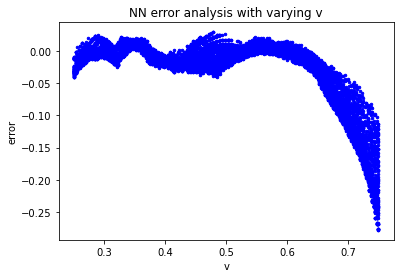

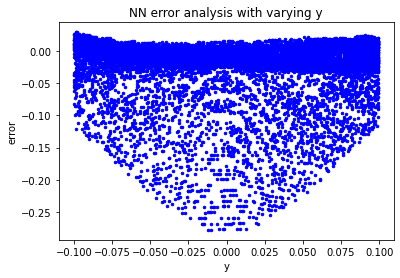

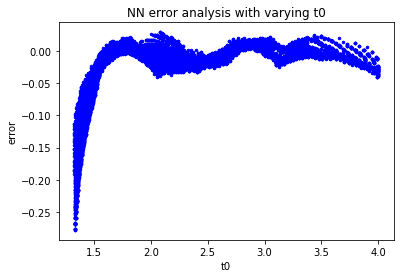

In [14]:
focus_point = 0.00
bin_width = 0.10
idx = np.where(((abs(results[:,3]-focus_point) <= bin_width)))			## index of elements is within the region that we are interested
data = results[idx]

pred = data[:,0]
target = data[:,1]
x = np.abs(data[:,2])
y = np.around(data[:,3], decimals=4)
v = np.around(data[:,4], decimals=4)

t0 = x/v
ty = y/v
error = pred - target
idx_max = np.argmax(np.abs(error))
print("idx with max error", idx_max)
print("error", error[idx_max])
print("x",x[idx_max])
print("y",y[idx_max])
print("v",v[idx_max])

plt.plot(v, error, color = 'b', marker=".", markersize=5,ls='None')
plt.xlabel('v')
plt.ylabel('error')
plt.title('NN error analysis with varying v')
plt.show()

plt.plot(y, error, color = 'b', marker=".", markersize=5,ls='None')
plt.xlabel('y')
plt.ylabel('error')
plt.title('NN error analysis with varying y')
plt.show()

plt.plot(t0, error, color = 'b', marker=".", markersize=5,ls='None')
plt.xlabel('t0')
plt.ylabel('error')
plt.title('NN error analysis with varying t0')
plt.show()


Therefore, we could see that this the region where y is very close to zero and the particle would be reflected to opposite direction. Moreover, if the intial velocity is higher the difference between $t_0$ and exact time would be much larger. Therefore, it makes the neural network more difficult to predict the exact interaction time. Also, there is another region for large error which is around the region of y=0.4.

idx with max error 147
error 0.24779516458511353
x 0.18360625207424164
y -0.983
v 0.25


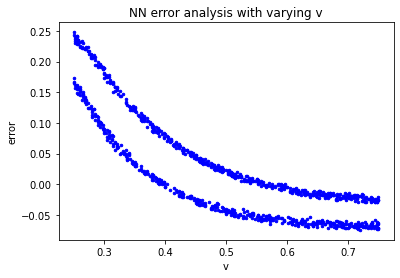

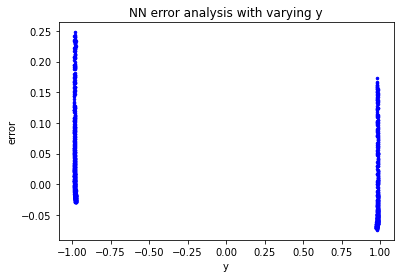

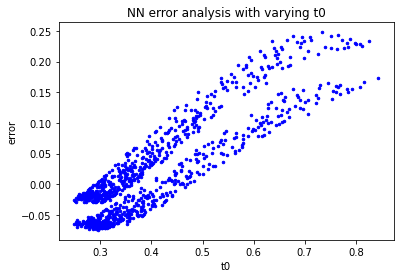

In [15]:
focus_point = 0.43
bin_width = 0.05
idx = np.where(((abs(results[:,1]-focus_point) <= bin_width)))			## index of elements is within the region that we are interested
data = results[idx]

pred = data[:,0]
target = data[:,1]
x = np.abs(data[:,2])
y = np.around(data[:,3], decimals=4)
v = np.around(data[:,4], decimals=4)

t0 = x/v
ty = y/v
error = pred - target
idx_max = np.argmax(np.abs(error))
print("idx with max error", idx_max)
print("error", error[idx_max])
print("x",x[idx_max])
print("y",y[idx_max])
print("v",v[idx_max])

plt.plot(v, error, color = 'b', marker=".", markersize=5,ls='None')
plt.xlabel('v')
plt.ylabel('error')
plt.title('NN error analysis with varying v')
plt.show()

plt.plot(y, error, color = 'b', marker=".", markersize=5,ls='None')
plt.xlabel('y')
plt.ylabel('error')
plt.title('NN error analysis with varying y')
plt.show()

plt.plot(t0, error, color = 'b', marker=".", markersize=5,ls='None')
plt.xlabel('t0')
plt.ylabel('error')
plt.title('NN error analysis with varying t0')
plt.show()


We can see that this is the region for one particle just interact with the edge of another particle. When the velocity of the particle is lower, the error is larger. This could be because the particle is at the edge of the interaction region, the particle could be kicked out of the region when it just entered and independent of the velocity. This is also a reason for the large error at this region.

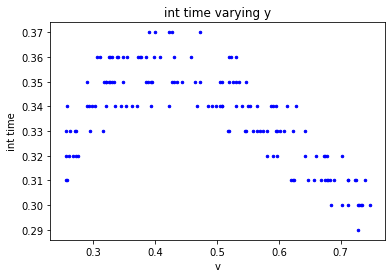

In [16]:
focus_point = 0.99
bin_width = 0.001
idx = np.where(((abs(results[:,3]-focus_point) <= bin_width)))			## index of elements is within the region that we are interested
data = results[idx]

pred = data[:,0]
target = data[:,1]
x = np.abs(data[:,2])
y = np.around(data[:,3], decimals=4)
v = np.around(data[:,4], decimals=4)

t0 = x/v
ty = y/v
error = pred - target
idx_max = np.argmax(np.abs(error))

plt.plot(v, target, color = 'b', marker=".", markersize=5,ls='None')
plt.xlabel('v')
plt.ylabel('int time')
plt.title('int time varying y')
plt.show()


# Classical Turning Point

We can compute the classical turning point analytically, which is the closest point between the particle and the COM. Then we can also compute the velocity along the direction towards COM and we can finally compute the guess of the interaction time which is given by the closest point divided by the velocity towards COM.

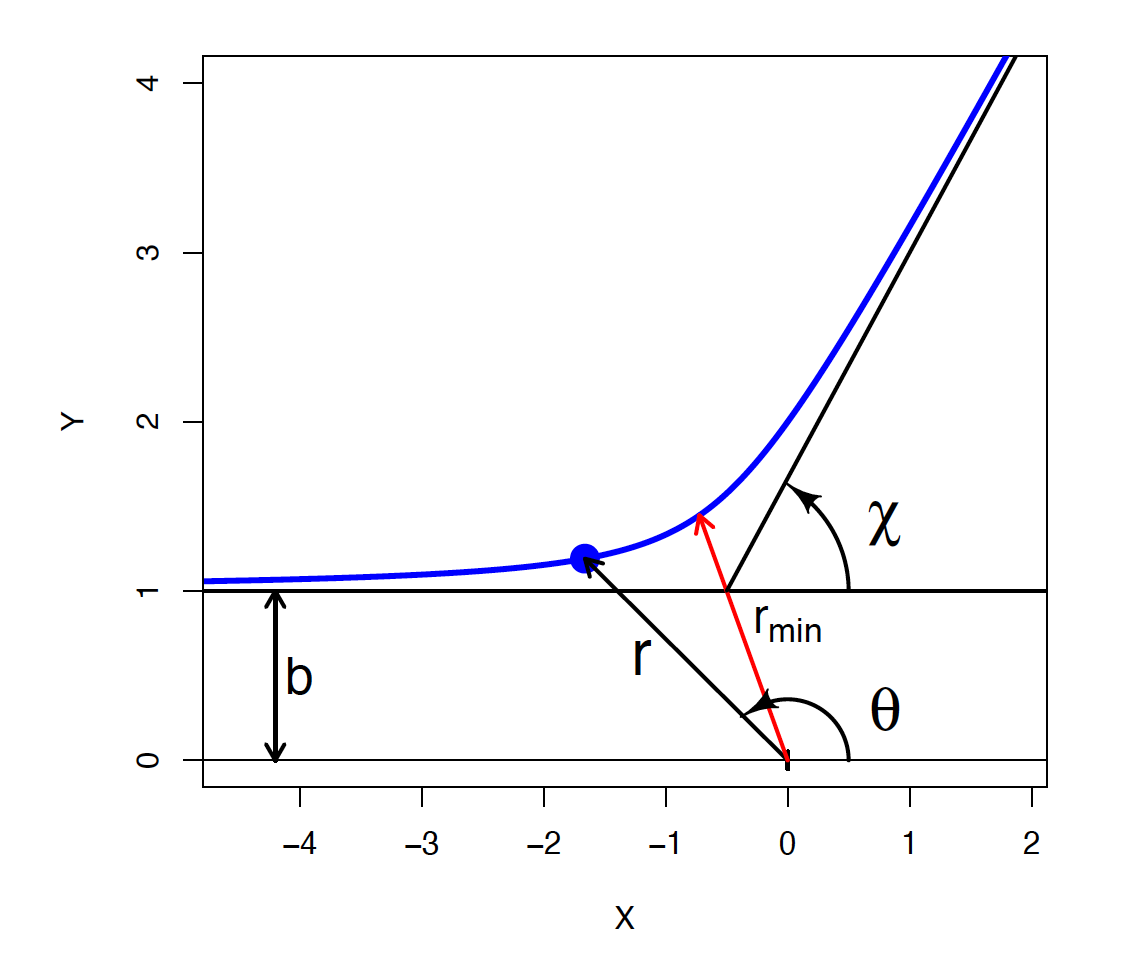

In the classical scattering theory, we consider the particle in polar coordinate:
$$ r(t) =  r(t)\hat{r}(t) $$
and the velocity is given by
$$ v =  \dot{r}\hat{r} + r\dot{\theta}\hat{\theta} $$
the angular momentum is given by
$$ L = mr 	\times v = mr^2\dot{\theta}  $$
$\theta$ is initially equal to $\pi$, and continuously decreases with time,
$$ \dot{\theta} = -\frac{L}{mr^2}  $$
As $r\to∞$, at the end of the scattering event, $\dot{\theta} \to ∞$, and $\theta \to$some constant, therefore, we can eliminating $\dot{\theta}$ in $v$
$$ v^2 = r^2 + \frac{L^2}{m^2r^2} $$
The total relative energy is 
$$ E = \frac{1}{2}mv^2 + V(r) = \frac{1}{2}m\dot{r}^2 + V_{eff}(r) $$
where
$$ V_{eff}(r) = V(r) + \frac{L^2}{2mr^2} $$
Before the collision event, the incident particle has only kinetic energy, and the total constant energy $E$. The constant angular momentum $L$ is then given by
$$  L = -b\sqrt{2mE} $$
At classical turning point$r_{min}$, $\dot{r} =0$ and it is defined by
$$ E = V_{eff}(r_{min}) $$

And here the potential that we are using is 
$$ V(r) = \frac{1}{1 + r^2} - \frac{1}{1 + d_0^2} $$
where $d_0$ is the interactive radius of the potential.

We can then write down
$$ E = \frac{1}{1 + r_{min}^2} - \frac{1}{1 + d_0^2} + \frac{b^2 E}{mr_{min}^2} $$
where $m=1$ in our case.

We can then rearrange the equation into
$$ 4(E +\frac{1}{1+d_0^2})r_{min}^4 + (E +\frac{1}{1+d_0^2} - 4Eb^2 - 1)r_{min}^2 - Eb^2 = 0 $$
where $E$ is the energy of the particle and $b$ is the impact factor, and both are known. We can then compute the classical turning point as the maximum positive roots by solving the above polynomial.

Then we compute the velocity of the particle along the direction towards COM $v_c$. When $b$ is larger, $v_c$ is smaller. 
$$ sin(\phi) = \frac{2b}{d}  $$
$$ v_c = vcos(\phi)  $$
Therefore, we can determine the initial guess of the interaction time, which is given by
$$ t_0 = 2 \frac{d_0 - 2r_{min}}{v_c}   $$

In [17]:
y = np.around(results[:,3], decimals=4)         ## Position of y of particle 1
v = np.around(results[:,4], decimals=4)         ## Velocity of particle 1

E = np.square(v)                                ## Inertial energy of particle 1(only KE)
b = np.abs(y)                                   ## Impact factor(define from classical scattering theory)
d0 = 2.0                                        ## The interactive radius

r_min = np.zeros(len(E))                        ## Classical turning point

### Obtaining the classical turning point from the maximum positive roots of the polynomial ###
for i in range(len(E)):
  p = [4.*(E[i] + 1./(1.+d0*d0)),0,((E[i] + 1./(1.+d0*d0)) - 4.*E[i]*b[i]*b[i] - 1.),0,-1.*E[i]*b[i]*b[i]]
  roots = np.roots(p)
  roots = np.real(np.max(roots[np.isreal(roots)]))
  r_min[i] += roots

phi = np.arcsin(b*2/d0)
v_c = v*np.cos(phi)
t0 = ((d0 - r_min*2)/v_c)*2


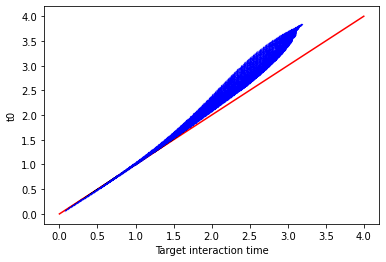

In [18]:
target = results[:,1]

plt.plot([0,1, 2, 3,4], c='r')
plt.plot(target, t0, color = 'b', marker=".", markersize=0.05,ls='None')
plt.xlabel('Target interaction time')
plt.ylabel('t0')
#plt.title('initial guess and exact interaction time')
plt.show()

We can see that the initial guess of the interaction time is alreadt quite close to the target, especially fot the short time interaction. We can use this as a starting point of our neural network.

Since we cannot solve the polynomial with pytorch, we have to do this with numpy. Therefore, I create the new set of training data which include the initial guess of interaction time $t_0$. Moreover, the training set is in COM frame for the convenience.

In [46]:
def load_data(batch_size=1):
  data = np.load('gdrive/My Drive/com_data.npy', allow_pickle=True)
  inputs = data[:,:3]
  targets = data[:,3:]

  inputs, inputs_valid, targets, targets_valid = train_test_split(inputs, targets, test_size=0.2,train_size=0.8)
  inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.2,train_size=0.8)

  inputs_train = torch.FloatTensor(inputs_train)
  targets_train = torch.FloatTensor(targets_train)

  inputs_valid = torch.FloatTensor(inputs_valid)
  targets_valid = torch.FloatTensor(targets_valid)

  inputs_test = torch.FloatTensor(inputs_test)
  targets_test = torch.FloatTensor(targets_test)

  train_data = TensorDataset(inputs_train.to(device=device), targets_train.to(device=device))
  valid_data = TensorDataset(inputs_valid.to(device=device), targets_valid.to(device=device))
  test_data = TensorDataset(inputs_test.to(device=device), targets_test.to(device=device))

  train_data_loader = DataLoader(train_data, batch_size=batch_size)
  valid_data_loader = DataLoader(valid_data, batch_size=batch_size)
  test_data_loader = DataLoader(test_data, batch_size=batch_size)

  return train_data_loader, valid_data_loader, test_data_loader

def train(train_data_loader, valid_data_loader, max_epoch, model):
  optimizer = optim.Adam(list(model.parameters()), lr=lr)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)
  best_val_loss = np.inf
  best_epoch = 0

  for epoch in range(max_epoch):
    t = time.time()
    loss_train = []
    loss_val = []
    model.train()
    for batch_idx, (data, targets) in enumerate(train_data_loader):
      r_min = targets[:,5]		  ## classical turning point             
      t0 = targets[:,6]			    ## initial guess
      targets = targets[:,0]    ## Target interaction time
      targets = targets[:,None]
      optimizer.zero_grad()
      output = model(data, r_min, t0)
      loss = F.mse_loss(output, targets)   ## Compute the loss between the prediction and targets
      loss.backward()
      optimizer.step()
      scheduler.step()
      loss_train.append(loss.data.detach().cpu().numpy())

    model.eval()
    for batch_idx, (data, targets) in enumerate(valid_data_loader):
      with torch.no_grad():
        r_min = targets[:,5]		## classical turning point
        t0 = targets[:,6]			  ## initial guess
        targets = targets[:,0]  ## Target interaction time
        targets = targets[:,None]
        output = model(data, r_min, t0)
        loss = F.mse_loss(output, targets)
        loss_val.append(loss.data.detach().cpu().numpy())

    print('Epoch: {:04d}'.format(epoch),
    'loss_train: {:.10f}'.format(np.mean(loss_train)),
    'loss_val: {:.10f}'.format(np.mean(loss_val)),
    'time: {:.4f}s'.format(time.time() - t))

    val_loss = np.mean(loss_val)
    if val_loss < best_val_loss:
      best_epoch = epoch
      best_val_loss = val_loss
      best_model = model.state_dict()
  print("Optimization Finished!")
  print("Best Epoch Loss: ", best_val_loss)
  print("Best Epoch: {:04d}".format(best_epoch))
  return best_model

def test(test_data_loader, model):
  t = time.time()
  loss_test = []
  input_list = []
  output_list = []
  targets_list = []
  model.eval()
  model.load_state_dict(best_model)
  for batch_idx, (data, targets) in enumerate(test_data_loader):
    with torch.no_grad():
      r_min = targets[:,5]		## classical turning point
      t0 = targets[:,6]			  ## initial guess
      targets = targets[:,0]  ## Target interaction time
      targets = targets[:,None]
      output = model(data, r_min, t0)
      loss = F.mse_loss(output, targets)
      loss_test.append(loss.data.detach().cpu().numpy())
      output_list.append(output.data.detach().cpu().numpy())
      targets_list.append(targets.data.detach().cpu().numpy())
      input_list.append(data.data.detach().cpu().numpy())

  print('loss_test: {:.10f}'.format(np.mean(loss_test)))
  output = np.concatenate(output_list, axis=0)
  targets = np.concatenate(targets_list, axis=0)
  input = np.concatenate(input_list, axis=0)
  results = np.empty((len(targets),5))
  for i in range(len(targets)):
    results[i,0] = output[i,0]
    results[i,1] = targets[i,0]
    results[i,2] = input[i,0]
    results[i,3] = input[i,1]
    results[i,4] = input[i,2]
  return results


class int_time_NN(nn.Module):
  def __init__(self, n_hid, num_levels):
    super(int_time_NN, self).__init__()
    self.hl1 = nn.Linear(5,n_hid)
    self.linear = nn.Linear(n_hid,n_hid)
    self.ol = nn.Linear(n_hid,1)
    self.relu = nn.ReLU()

    layers = []
    for i in range(num_levels):
      layers += [nn.Sequential(self.linear, self.relu)]
    self.hl2 = nn.Sequential(*layers)

  def forward(self, inputs, r_min, t0):
    x = inputs[:,0]
    y = inputs[:,1]
    v = inputs[:,2]

    E = torch.square(v)	                ## Total Energy of the particle
    J = y*v                             ## Angular momentum
    E_rot = J/2./torch.square(r_min)    ## Rotational energy of the particle at the classical turning point
    E_ke = E - E_rot                    ## Kinetic energy of theparticle at the classical turning point

    x = torch.abs(x[:,None])
    y = torch.abs(y[:,None])
    v = torch.abs(v[:,None])
    t0 = torch.abs(t0[:,None])
    E_ke = torch.abs(E_ke[:,None])
    E_rot = torch.abs(E_rot[:,None])

    inputs = torch.cat((y,v,t0,E_ke,E_rot),axis=-1)
    intermediate  = self.relu(self.hl1(inputs))
    intermediate  = self.hl2(intermediate)
    intermediate  = self.ol(intermediate)
    output = t0*(1. - intermediate)
    return output 


Epoch: 0000 loss_train: 0.0009170559 loss_val: 0.0000349673 time: 6.6688s
Epoch: 0001 loss_train: 0.0000342132 loss_val: 0.0000347991 time: 6.6246s
Epoch: 0002 loss_train: 0.0000341788 loss_val: 0.0000347986 time: 6.5906s
Epoch: 0003 loss_train: 0.0000341788 loss_val: 0.0000347986 time: 6.5884s
Epoch: 0004 loss_train: 0.0000341788 loss_val: 0.0000347986 time: 6.7225s
Optimization Finished!
Best Epoch Loss:  3.4798584e-05
Best Epoch: 0002
loss_test: 0.0000342575


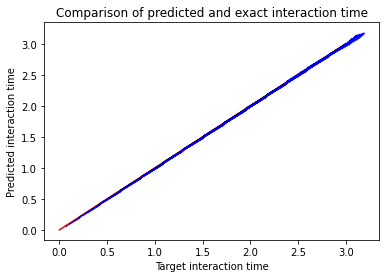

In [47]:
n_hid = 32
num_levels = 3
train_data_loader, valid_data_loader, test_data_loader = load_data(batch_size=batch_size)
model = int_time_NN(n_hid=n_hid, num_levels=num_levels).to(device=device)
best_model = train(train_data_loader, valid_data_loader, max_epoch, model)
results = test(test_data_loader, model)
plot(results)